In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'


import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.7 MB/s eta 0:00:00


Data shape: (1048575,)


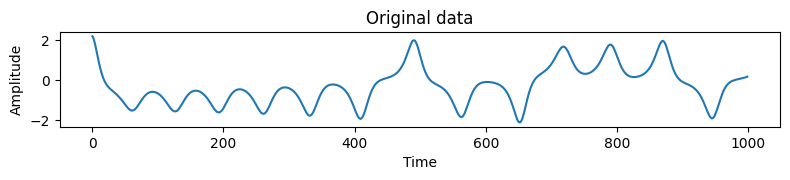

In [3]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

# standardization
mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

#######
#Visualization

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Input gate $i_t$,

Forget gate $f_t$,

Output gate $o_t$,

$h$: Sigmoid and omit biases:
\begin{equation*}
\begin{split}
i_t&=h(W_{datain}d_t+W_{gatein}x_{t-1}),\\
f_t&=h(W_{dataforget}d_t+W_{forget}x_{t-1}),\\
o_t&=h(W_{dataout}d_t+W_{gateout}x_{t-1}),\\
%\tilde c_t&=
\end{split}
\end{equation*}
Memory cell (CEC) $c_t$:
\begin{equation*}
c_t=i_t\odot \tanh(W_{datacell}d_t+W_{cell}x_{t-1})+f_t\odot c_{t-1}
\end{equation*}
Output layer:
\begin{equation*}
x_t=o_t\odot\tanh(c_t)
\end{equation*}

 The operator $\odot$ denotes the Hadamard product (element-wise product).

In [4]:
# @title Definition of LSTM

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

 # Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def make_connection(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

####################
def sigmoid(x):

    #return 0.5 * (1 + np.tanh(x / 2))
    return 1 / (1 + np.exp(-x))


def Reservoir(x_in,x,W):

        x =  np.tanh(np.dot(W, x) + x_in)
        return x

def Gate(x_in,x,W):

        x =  sigmoid(np.dot(W, x) + x_in)
        return x
######################

def LSTM(x,c,x_gatein,Wgatein,x_cell,Wcell,x_forget,Wforget,x_gateout,Wgateout):

        c = Gate(x_gatein,x,Wgatein) * Reservoir(x_cell,x,Wcell) +Gate(x_forget,x,Wforget) *c
        x = Gate(x_gateout,x,Wgateout) * np.tanh(c)

        return x,c

####################
#Ridge Regression and  Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x,c, T_train,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len):

    x = np.zeros(N_x)
    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):


            # reservoir state vector
        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

            # teacher data
        d = train_D[n,:]

        if n > discard_len:   # discard the first part of the data
            X_XT, D_XT = Ridge(d, x, X_XT, D_XT)
            #X_XT, D_XT = Ridge(d, c, X_XT, D_XT) #Peephole

    return X_XT, D_XT,x,c

########################
#induction formula for creating estimated data
########################

def run(test_U,x,c,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test):

    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x,c = LSTM(x,c,np.dot(Wdatain,y),Wgatein, np.dot(Wdatacell,y), \
                   Wcell,np.dot(Wdataforget,y),Wforget,np.dot(Wdataout,y),Wgateout)

        y_pred = np.dot(Wout, x)
        #y_pred = np.dot(Wout, c) #Peephole
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [5]:
# @title Definition of Bayesian optimization of LSTM

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))


################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 28)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density_gate = trial.suggest_float("density_gate", 0.01, 1)
    density_res = trial.suggest_float("density_res", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho_gate = trial.suggest_float("rho_gate", 0, 1.5)
    rho_res = trial.suggest_float("rho_res", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value_datain = trial.suggest_float("seed_value_datain", 0, 100)
    seed_value_gatein = trial.suggest_float("seed_value_gatein", 0, 100)
    seed_value_datacell = trial.suggest_float("seed_value_datacell", 0, 100)
    seed_value_cell = trial.suggest_float("seed_value_cell", 0, 100)
    seed_value_dataforget = trial.suggest_float("seed_value_dataforget", 0, 100)
    seed_value_forget = trial.suggest_float("seed_value_forget", 0, 100)
    seed_value_dataout = trial.suggest_float("seed_value_dataout", 0, 100)
    seed_value_gateout = trial.suggest_float("seed_value_gateout", 0, 100)

###############

    T_0 = T_train + lag * dim
###############
#Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

###############
#Convert data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

        data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]

# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)
    c_special = np.zeros(N_x)

    X_XT, D_XT,x_special,c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

 # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

##############################
#Calculate RMSE (we can compare with TensorFlow)
##############################

    pred_D = np.zeros((T_train,dim), dtype=float)
    x = np.zeros(N_x)
    c = np.zeros(N_x)

    for n in range(T_train):

        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

        pred_D[n,:] = np.dot(Wout, x)
        #pred_D[n,:] = np.dot(Wout, c) #Peephole

    return np.sqrt(np.mean((pred_D[discard_len:]-train_D[discard_len:])**2))

1048575
CPU times: user 759 µs, sys: 3 µs, total: 762 µs
Wall time: 1.24 ms


In [6]:
# @title Implementation of Bayesian optimization of LSTM

%%time

n_trials = 30    # Number of times to test with optuna (generate RMSE for this number of times)
T_train = 5000   # Training period
T_test = 100     # Forecast period
Node = 70        # Node

discard_len = 10 # Number of steps not learned at the beginning (not important）

MAX_TRIALS = 8   # Repeat the same thing while shifting each one step to produce robust result


test_num = 3000  # Number of times for one test (to get one generalization error in MAE)
synchro_len=170  #Steps to generate initial hidden layer vector

#########################

mean_score  = []
score       = []

#########################
#Convert data to Implement set for each trial

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials)

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density_gate = trial.params["density_gate"]
    density_res  = trial.params["density_res"]
    input_scale  = trial.params["input_scale"]
    rho_gate     = trial.params["rho_gate"]
    rho_res      = trial.params["rho_res"]
    alpha        = trial.params["alpha"]
    seed_value_datain     = trial.params["seed_value_datain"]
    seed_value_gatein     = trial.params["seed_value_gatein"]
    seed_value_datacell   = trial.params["seed_value_datacell"]
    seed_value_cell       = trial.params["seed_value_cell"]
    seed_value_dataforget = trial.params["seed_value_dataforget"]
    seed_value_forget     = trial.params["seed_value_forget"]
    seed_value_dataout    = trial.params["seed_value_dataout"]
    seed_value_gateout    = trial.params["seed_value_gateout"]

###################################
##Training phase
###################################
    #Test start time

    T_0 = T_train+lag*dim

    #Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

    #Convert training data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

          data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]  # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

    #Ridge
    X_XT, D_XT,x_special, c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

    #Generate output weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)


###################################
##Test phase
###################################


    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

    #Convert test data to a delay coordinate system

    for t in range(test_num):

          for i in range(dim):

              data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                            :T_0+t+T_test-i*lag+1]


    # Initialization of test data

    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))

    ##The last time data of the training data output must overlap with the test data!

    x_conti = np.zeros((N_x), dtype=float)
    c_conti = np.zeros((N_x), dtype=float)

    for t in range(test_num):


        X_XT, D_XT,x_conti,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                    data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),np.zeros(N_x),synchro_len,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,0)

        #Predictive data generation

        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_conti,c_conti,Wdatain,Wgatein,Wdatacell, \
                                      Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test)

        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1
                                :T_train+T_test+1,0,t]

    mae = MAE( test_Y[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('Average of MAE:',np.mean(score))


[I 2025-08-25 01:35:15,699] A new study created in memory with name: no-name-97b52912-55e5-4b7e-b23f-96fc63836447


Trial 1/8


[I 2025-08-25 01:35:18,036] Trial 0 finished with value: 0.009494896373445938 and parameters: {'lag': 4, 'dim': 16, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.8193353007132007, 'density_res': 0.21824017326360634, 'input_scale': 0.49524024699751945, 'rho_gate': 0.9461503069651935, 'rho_res': 0.36687038340942574, 'alpha': 0.07928851664365844, 'seed_value_datain': 6.487107174229633, 'seed_value_gatein': 27.2944315603623, 'seed_value_datacell': 36.556751767312036, 'seed_value_cell': 97.79693742656472, 'seed_value_dataforget': 57.34271556628472, 'seed_value_forget': 99.97031377972296, 'seed_value_dataout': 55.55609288932788, 'seed_value_gateout': 85.6665012910564}. Best is trial 0 with value: 0.009494896373445938.
[I 2025-08-25 01:35:21,203] Trial 1 finished with value: 0.002146315536130055 and parameters: {'lag': 6, 'dim': 3, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.5864923756873823, 'density_res': 0.9047804544857937, 'input_scale': 0.5826630122356913, 'rho_gate': 0.894621868142826, 

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7668405708193273, 'density_res': 0.8345199997065185, 'input_scale': 0.11460086594571556, 'rho_gate': 0.5534758130961712, 'rho_res': 1.3643969218962364, 'alpha': 0.5080283696922154, 'seed_value_datain': 86.88006633950131, 'seed_value_gatein': 43.031598551626494, 'seed_value_datacell': 70.33429073206771, 'seed_value_cell': 83.86124445356322, 'seed_value_dataforget': 87.47273529412912, 'seed_value_forget': 65.41992050280442, 'seed_value_dataout': 52.83130532478289, 'seed_value_gateout': 32.12972389837256},
  'value': 0.0020055204228888062,


[I 2025-08-25 01:37:07,482] A new study created in memory with name: no-name-b4d87c89-df92-470c-b6a2-83276dee51b9


MAE: 0.44638276905059476
Average of MAE: 0.44638276905059476
Trial 2/8


[I 2025-08-25 01:37:08,669] Trial 0 finished with value: 0.047773830615038454 and parameters: {'lag': 4, 'dim': 22, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.10797687911147939, 'density_res': 0.13062976492302875, 'input_scale': 0.6747144500519493, 'rho_gate': 0.8908695071455202, 'rho_res': 1.2860114570003063, 'alpha': 0.3184610639495229, 'seed_value_datain': 67.30053934657325, 'seed_value_gatein': 48.835531826895895, 'seed_value_datacell': 20.78989072538755, 'seed_value_cell': 40.78757478817966, 'seed_value_dataforget': 62.65118922296664, 'seed_value_forget': 9.963531054461395, 'seed_value_dataout': 79.71738718095126, 'seed_value_gateout': 10.64306280553211}. Best is trial 0 with value: 0.047773830615038454.
[I 2025-08-25 01:37:09,774] Trial 1 finished with value: 0.062112139832759254 and parameters: {'lag': 6, 'dim': 14, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6076161416866367, 'density_res': 0.21279294604987978, 'input_scale': 0.9843566383913901, 'rho_gate': 1.082706090381536

Best trial:
  'params': {'lag': 3, 'dim': 9, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7353540616754219, 'density_res': 0.45504286611810985, 'input_scale': 0.22518495667171096, 'rho_gate': 1.1018476261318384, 'rho_res': 0.8516564597174884, 'alpha': 0.8220929523697434, 'seed_value_datain': 96.64457137586002, 'seed_value_gatein': 98.17548562658803, 'seed_value_datacell': 83.70017215562228, 'seed_value_cell': 30.115572628884223, 'seed_value_dataforget': 22.81809156138761, 'seed_value_forget': 57.8904383456328, 'seed_value_dataout': 72.60826956224834, 'seed_value_gateout': 10.653423842537624},
  'value': 0.001970308392966504,


[I 2025-08-25 01:38:42,064] A new study created in memory with name: no-name-b630a353-cef7-46fa-a0f5-5a40ae771456


MAE: 0.34847836752072536
Average of MAE: 0.39743056828566004
Trial 3/8


[I 2025-08-25 01:38:42,794] Trial 0 finished with value: 0.0071340956690302115 and parameters: {'lag': 8, 'dim': 13, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.8892954775001947, 'density_res': 0.5000267259553536, 'input_scale': 0.1363648081581147, 'rho_gate': 0.9446223348556879, 'rho_res': 0.40672661255358383, 'alpha': 0.7094065958749921, 'seed_value_datain': 67.06562522092243, 'seed_value_gatein': 43.30756551426829, 'seed_value_datacell': 92.0916975470834, 'seed_value_cell': 22.288429912992946, 'seed_value_dataforget': 68.39007530241393, 'seed_value_forget': 57.35409737394354, 'seed_value_dataout': 45.10542157022597, 'seed_value_gateout': 15.143155741426174}. Best is trial 0 with value: 0.0071340956690302115.
[I 2025-08-25 01:38:43,526] Trial 1 finished with value: 0.13049731882910492 and parameters: {'lag': 10, 'dim': 13, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.5236177368936026, 'density_res': 0.5467382906831884, 'input_scale': 1.357056424852164, 'rho_gate': 0.9653409952360291

Best trial:
  'params': {'lag': 5, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.5735492504982691, 'density_res': 0.9921055644031639, 'input_scale': 0.48717972610759397, 'rho_gate': 0.15364727081172153, 'rho_res': 0.470876400473319, 'alpha': 0.6320641806764736, 'seed_value_datain': 90.12141621126389, 'seed_value_gatein': 72.67972536741412, 'seed_value_datacell': 40.46757614567948, 'seed_value_cell': 66.44536359007671, 'seed_value_dataforget': 74.33972401109463, 'seed_value_forget': 11.412343057223449, 'seed_value_dataout': 90.75022303672694, 'seed_value_gateout': 9.252021629567245},
  'value': 0.0021216140867387095,


[I 2025-08-25 01:40:15,160] A new study created in memory with name: no-name-de7e0c48-6c5a-4434-9048-14f001834b36


MAE: 0.19751040079574003
Average of MAE: 0.3307905124556867
Trial 4/8


[I 2025-08-25 01:40:15,886] Trial 0 finished with value: 0.04026468217508142 and parameters: {'lag': 3, 'dim': 17, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.06512479020808715, 'density_res': 0.15506555332968225, 'input_scale': 1.1372048326522113, 'rho_gate': 0.3642562203221086, 'rho_res': 0.014592924123696005, 'alpha': 0.4607964807326288, 'seed_value_datain': 31.814518026225326, 'seed_value_gatein': 67.14214681880408, 'seed_value_datacell': 25.613077023180775, 'seed_value_cell': 48.35089254144053, 'seed_value_dataforget': 87.08519148437162, 'seed_value_forget': 22.76602653894595, 'seed_value_dataout': 90.15842918644306, 'seed_value_gateout': 40.400758735694744}. Best is trial 0 with value: 0.04026468217508142.
[I 2025-08-25 01:40:16,611] Trial 1 finished with value: 0.002153812536830558 and parameters: {'lag': 4, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6997982556396102, 'density_res': 0.326298321411482, 'input_scale': 0.48129965925732104, 'rho_gate': 0.476874219543575

Best trial:
  'params': {'lag': 3, 'dim': 5, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.8691442705411857, 'density_res': 0.996017011434591, 'input_scale': 0.3144079903633178, 'rho_gate': 0.32859267045952123, 'rho_res': 0.1094095761682039, 'alpha': 0.8524234948660341, 'seed_value_datain': 46.45541855312887, 'seed_value_gatein': 71.88558344028948, 'seed_value_datacell': 88.25578752156329, 'seed_value_cell': 87.31156392477523, 'seed_value_dataforget': 76.33843237125083, 'seed_value_forget': 42.84558397625033, 'seed_value_dataout': 89.16621829201848, 'seed_value_gateout': 45.821958429888085},
  'value': 0.002029865953166227,


[I 2025-08-25 01:41:49,055] A new study created in memory with name: no-name-5658ec5d-6997-4ea0-90cf-910f5636b3bb


MAE: 0.2480637947254277
Average of MAE: 0.3101088330231219
Trial 5/8


[I 2025-08-25 01:41:50,224] Trial 0 finished with value: 0.07266685372139801 and parameters: {'lag': 8, 'dim': 14, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.2099796819204458, 'density_res': 0.1334765294023593, 'input_scale': 0.8842879020428847, 'rho_gate': 0.712627401889422, 'rho_res': 0.0499446002893737, 'alpha': 0.31411665462886906, 'seed_value_datain': 45.69315211863013, 'seed_value_gatein': 64.77991646561836, 'seed_value_datacell': 79.39181368344853, 'seed_value_cell': 6.213197393979253, 'seed_value_dataforget': 40.815211534110695, 'seed_value_forget': 97.80960278909151, 'seed_value_dataout': 48.705140162734665, 'seed_value_gateout': 68.00260765330094}. Best is trial 0 with value: 0.07266685372139801.
[I 2025-08-25 01:41:50,947] Trial 1 finished with value: 0.0144555810794579 and parameters: {'lag': 5, 'dim': 7, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7684790246245197, 'density_res': 0.03218670328394124, 'input_scale': 1.4492215941433924, 'rho_gate': 0.023547567122147395, '

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.42786743230672686, 'density_res': 0.5830718015620023, 'input_scale': 0.2719761217434273, 'rho_gate': 0.5269173949558789, 'rho_res': 1.487537193627734, 'alpha': 0.5421128331988276, 'seed_value_datain': 55.95893508942263, 'seed_value_gatein': 44.96225823503132, 'seed_value_datacell': 17.786803908445602, 'seed_value_cell': 88.86366855365, 'seed_value_dataforget': 87.32409657344871, 'seed_value_forget': 69.65213432603682, 'seed_value_dataout': 13.610941924183667, 'seed_value_gateout': 45.57889305979252},
  'value': 0.0019502333670124586,


[I 2025-08-25 01:43:21,997] A new study created in memory with name: no-name-ed2aeedd-d030-4760-9a3f-bc504416e93f


MAE: 0.2444639125081809
Average of MAE: 0.29697984892013374
Trial 6/8


[I 2025-08-25 01:43:22,744] Trial 0 finished with value: 0.025487533666420904 and parameters: {'lag': 6, 'dim': 7, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.3961546748638831, 'density_res': 0.9173389865163893, 'input_scale': 1.3451661716229832, 'rho_gate': 0.7222889667685243, 'rho_res': 1.0740090121857415, 'alpha': 0.2518766722625029, 'seed_value_datain': 79.34484467575942, 'seed_value_gatein': 8.182307246553112, 'seed_value_datacell': 3.8733897916444104, 'seed_value_cell': 36.05813672220762, 'seed_value_dataforget': 27.150483103027334, 'seed_value_forget': 18.944693805917545, 'seed_value_dataout': 62.21802655695856, 'seed_value_gateout': 62.41195749922355}. Best is trial 0 with value: 0.025487533666420904.
[I 2025-08-25 01:43:23,506] Trial 1 finished with value: 0.18481840978039818 and parameters: {'lag': 8, 'dim': 28, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7455950675647927, 'density_res': 0.618996566421184, 'input_scale': 0.577954534420442, 'rho_gate': 0.15724268776181255, '

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.3333104420658474, 'density_res': 0.2651793637450887, 'input_scale': 0.3339830635921499, 'rho_gate': 1.0843862603975438, 'rho_res': 0.6112383126799451, 'alpha': 0.9999636018188596, 'seed_value_datain': 99.59964459331755, 'seed_value_gatein': 92.89240411514307, 'seed_value_datacell': 17.434784397012656, 'seed_value_cell': 57.453659832398984, 'seed_value_dataforget': 56.13493901290312, 'seed_value_forget': 92.31527670370846, 'seed_value_dataout': 99.8649846382345, 'seed_value_gateout': 14.280028847409575},
  'value': 0.0019660974502357874,


[I 2025-08-25 01:44:54,784] A new study created in memory with name: no-name-87d8a73f-0eb7-49e3-9924-c9611b303fe3


MAE: 0.14660915294564952
Average of MAE: 0.2719180662577197
Trial 7/8


[I 2025-08-25 01:44:55,512] Trial 0 finished with value: 0.05031149995623732 and parameters: {'lag': 3, 'dim': 19, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.8200111407685814, 'density_res': 0.16508283488147016, 'input_scale': 1.4514187837544423, 'rho_gate': 0.030029669332112652, 'rho_res': 0.40752160049289726, 'alpha': 0.6007072707583367, 'seed_value_datain': 45.42325412154289, 'seed_value_gatein': 20.770985762861503, 'seed_value_datacell': 19.36031066808117, 'seed_value_cell': 77.75025929086844, 'seed_value_dataforget': 85.44656210868338, 'seed_value_forget': 44.85883174622701, 'seed_value_dataout': 0.9097178356841984, 'seed_value_gateout': 5.289473119856581}. Best is trial 0 with value: 0.05031149995623732.
[I 2025-08-25 01:44:56,233] Trial 1 finished with value: 0.011031841650837608 and parameters: {'lag': 8, 'dim': 11, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6641697030797791, 'density_res': 0.08555059568986594, 'input_scale': 0.3420929845769738, 'rho_gate': 0.10707725517497

Best trial:
  'params': {'lag': 3, 'dim': 8, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.40212332420341657, 'density_res': 0.36125140985472687, 'input_scale': 0.14070632168129033, 'rho_gate': 0.7239907129128407, 'rho_res': 0.3258891555267316, 'alpha': 0.1993429108424802, 'seed_value_datain': 74.09023644160322, 'seed_value_gatein': 59.18635745778694, 'seed_value_datacell': 30.285973658054356, 'seed_value_cell': 49.094956181063054, 'seed_value_dataforget': 50.506450366551164, 'seed_value_forget': 0.5360349311532964, 'seed_value_dataout': 88.97687557271718, 'seed_value_gateout': 58.79111293230116},
  'value': 0.0019929012907994085,


[I 2025-08-25 01:46:28,962] A new study created in memory with name: no-name-8145a6d5-d48c-444c-975b-65591f2a3256


MAE: 0.5247886958118516
Average of MAE: 0.3080424419083099
Trial 8/8


[I 2025-08-25 01:46:30,176] Trial 0 finished with value: 0.002511107618415863 and parameters: {'lag': 5, 'dim': 8, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.253732376684983, 'density_res': 0.7140492561799401, 'input_scale': 0.4349614206109758, 'rho_gate': 0.7201030715572581, 'rho_res': 1.0503999613562809, 'alpha': 0.8924211327662315, 'seed_value_datain': 32.19021773971081, 'seed_value_gatein': 88.45290893167073, 'seed_value_datacell': 78.39265103649547, 'seed_value_cell': 32.33649745637924, 'seed_value_dataforget': 66.15934490002962, 'seed_value_forget': 19.992178240651693, 'seed_value_dataout': 63.0297648001301, 'seed_value_gateout': 33.22463305460275}. Best is trial 0 with value: 0.002511107618415863.
[I 2025-08-25 01:46:31,018] Trial 1 finished with value: 0.10776625345241046 and parameters: {'lag': 8, 'dim': 23, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.022894949245909214, 'density_res': 0.6878298854095748, 'input_scale': 0.45020671023287373, 'rho_gate': 1.2087333988114208, '

Best trial:
  'params': {'lag': 3, 'dim': 5, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.17164321211659272, 'density_res': 0.5362463504959895, 'input_scale': 0.6184607667547473, 'rho_gate': 0.24800794854317715, 'rho_res': 1.061303781079296, 'alpha': 0.8987264763529148, 'seed_value_datain': 98.75321774562848, 'seed_value_gatein': 84.09978681420748, 'seed_value_datacell': 27.37879037295936, 'seed_value_cell': 30.134116846136294, 'seed_value_dataforget': 28.352963401978283, 'seed_value_forget': 41.25610475217143, 'seed_value_dataout': 84.86913869803546, 'seed_value_gateout': 44.69880962651702},
  'value': 0.0019842267973210516,
MAE: 0.18802385572388633
Average of MAE: 0.29304011863525703
CPU times: user 12min 41s, sys: 4.61 s, total: 12min 46s
Wall time: 12min 45s


Average of MAE: 0.29304011863525703


/tmp/ipython-input-4054014136.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


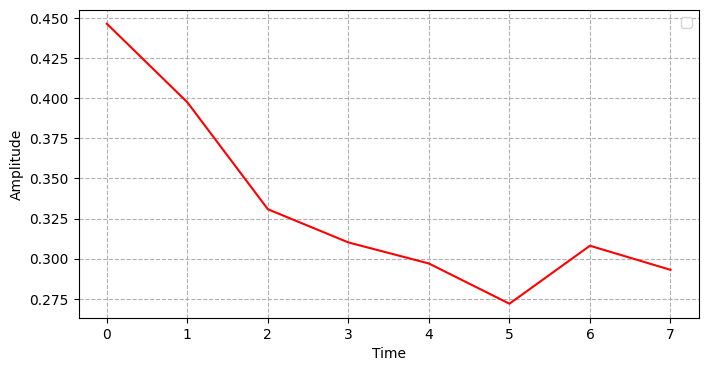

In [7]:
# @title Result of LSTM prediction

mean_score = np.array(mean_score)

import matplotlib.pyplot as plt


print('Average of MAE:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.18802385572388633
forecast period: 100


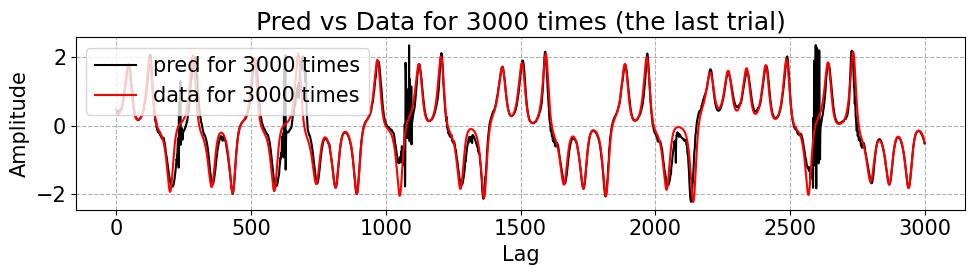

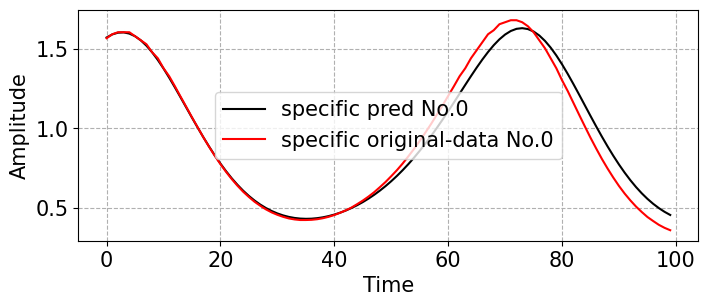

In [8]:
# @title Visualization (only the last trial)

print("MAE(the last trial):", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()